In [55]:
##########################################################
################ Load Packages / libraries ############### 
##########################################################
import os 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt
import seaborn as sns
from sklearn.cluster import KMeans, k_means
import pypyodbc as podbc


##########################################################
############## Configure notebook settings ############### 
##########################################################
np.set_printoptions(formatter={'float_kind':'{:f}'.format}) # To change scientific numbers to float
sns.set(rc={'figure.figsize':(8,6)}) # Increases the size of sns plots


In [56]:
##########################################################
########### Connect / Retrieve from SQL Server ########### 
##########################################################

con = podbc.connect("Driver={SQL Server Native Client 11.0};"
                     "Server=H510I\SQLEXPRESS;"
                     "Database=customers;"
                     "Trusted_Connection=yes;")

# Testing a query to confirm connection config
SQL_Query = pd.read_sql_query('''SELECT * FROM [dbo].[raw_data]''', con)
SQL_Query.head()

d:\CompSci\Projects\kmeans-clustering\.venv\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id,age,gender,postcode,district,constituency,latitude,longitude,current_status,total_household_income,how_often_you_attend_entertaining_events_in_a_year,social_media,how_many_hours_are_you_willing_to_travel_to_attend_an_event,do_you_enjoy_adrenaline_rush_activities,are_food_areas_important_to_you,favourite_attraction,were_you_satisfied_with_the_last_event_you_attended_with_us,would_you_recommend_our_events_to_other_people,did_you_find_our_events_value_for_money
0,1,40-49,Female,AL9 7BN,Welwyn Hatfield,Welwyn Hatfield,51.727429,-0.183648,Married with children,"50,000 to 74,999",4 Times a Year,Up to 1 hour,3 hours,Entirely disagree,Entirely agree,Ice Bar,Somewhat agree,Somewhat Unlikely,Somewhat disagree
1,2,60-64,Male,AL7 1ZW,Welwyn Hatfield,Welwyn Hatfield,51.804482,-0.195898,Married with children,"35,000 to 49,999",3 Times a Year,Up to 1 hour,5 hours,Somewhat disagree,Entirely agree,Happy Rollercoaster,Mostly agree,Somewhat Likely,Entirely disagree
2,3,50-59,Male,AB4 5JX,Aberdeenshire,Banff and Buchan,57.692200,-2.022295,Married with children,"75,000 to 99,999",3 Times a Year,I don't spend any time at all,5 hours,Somewhat disagree,Somewhat agree,Happy Rollercoaster,Mostly agree,Mostly Unlikely,Entirely disagree
3,4,50-59,Female,B24 0DL,Birmingham,"Birmingham, Erdington",52.526595,-1.822211,Married without children,"35,000 to 49,999",1 Times a Year,Half a day,1 hour,Entirely agree,Neither agree nor disagree,Crazy rollercoaster ride,Somewhat agree,Somewhat Likely,Somewhat disagree
4,5,60-64,Male,E17 5QP,Waltham Forest,Walthamstow,51.593979,-0.040803,Married with children,"100,000 to 149,999",3 Times a Year,Up to 1 hour,6 hours plus,Mostly disagree,Neither agree nor disagree,Kids Playground,Entirely agree,Very Unlikely,Entirely agree


In [59]:
##########################################################
################ Dealing with null values ################ 
##########################################################
SQL_Query.isnull().sum()

id                                                             0
age                                                            0
gender                                                         0
postcode                                                       0
district                                                       0
constituency                                                   0
latitude                                                       0
longitude                                                      0
current_status                                                 0
total_household_income                                         5
how_often_you_attend_entertaining_events_in_a_year             5
social_media                                                   5
how_many_hours_are_you_willing_to_travel_to_attend_an_event    5
do_you_enjoy_adrenaline_rush_activities                        5
are_food_areas_important_to_you                                5
favourite_attraction     

In [60]:
# Deleting the NULL values
SQL_Query = SQL_Query.dropna(subset = ['total_household_income'])

# Printing the shape
print(SQL_Query.shape)

# Visualize the NULL observations
SQL_Query.isnull().sum()

(14778, 19)


id                                                             0
age                                                            0
gender                                                         0
postcode                                                       0
district                                                       0
constituency                                                   0
latitude                                                       0
longitude                                                      0
current_status                                                 0
total_household_income                                         0
how_often_you_attend_entertaining_events_in_a_year             0
social_media                                                   0
how_many_hours_are_you_willing_to_travel_to_attend_an_event    0
do_you_enjoy_adrenaline_rush_activities                        0
are_food_areas_important_to_you                                0
favourite_attraction     

In [61]:
##########################################################
######### Select features & check element counts ######### 
##########################################################
features = SQL_Query.columns.values
rem = ['id','district', 'constituency', 'postcode', 'latitude', 'longitude'] #remove location based features
features = np.setdiff1d(features, rem)

for column in SQL_Query:
    unique_vals = np.unique(SQL_Query[column])
    nr_values = len(unique_vals)
    print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature id :14778
The number of values for feature age :9
The number of values for feature gender :2
The number of values for feature postcode :14674
The number of values for feature district :225
The number of values for feature constituency :358
The number of values for feature latitude :13242
The number of values for feature longitude :13262
The number of values for feature current_status :8
The number of values for feature total_household_income :8
The number of values for feature how_often_you_attend_entertaining_events_in_a_year :5
The number of values for feature social_media :5
The number of values for feature how_many_hours_are_you_willing_to_travel_to_attend_an_event :7
The number of values for feature do_you_enjoy_adrenaline_rush_activities :7
The number of values for feature are_food_areas_important_to_you :7
The number of values for feature favourite_attraction :7
The number of values for feature were_you_satisfied_with_the_last_event_you_attended_

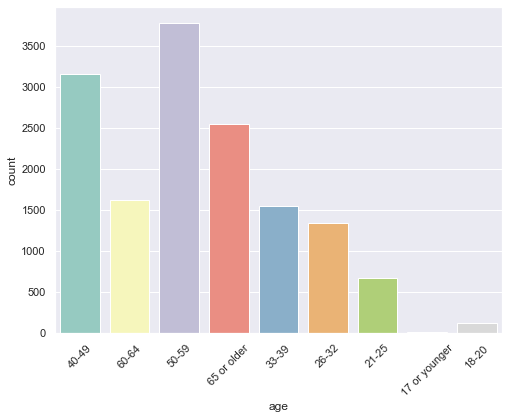

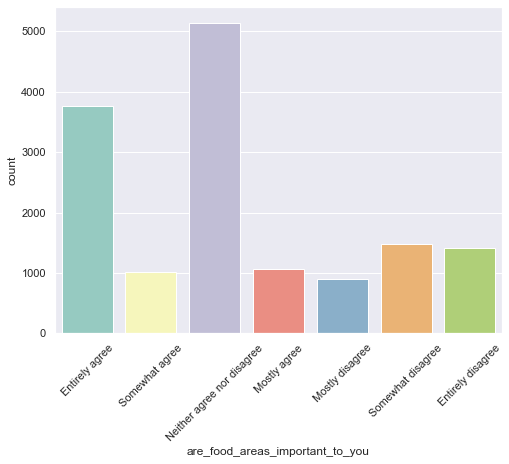

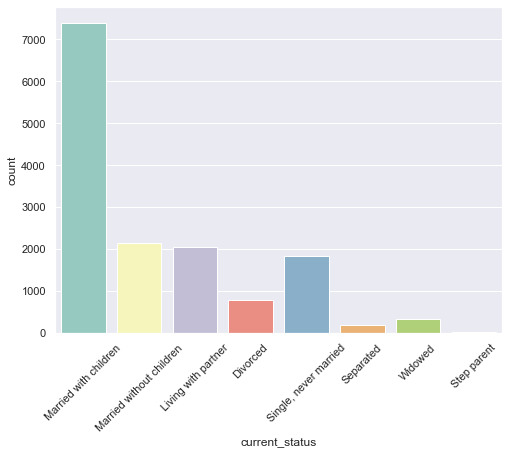

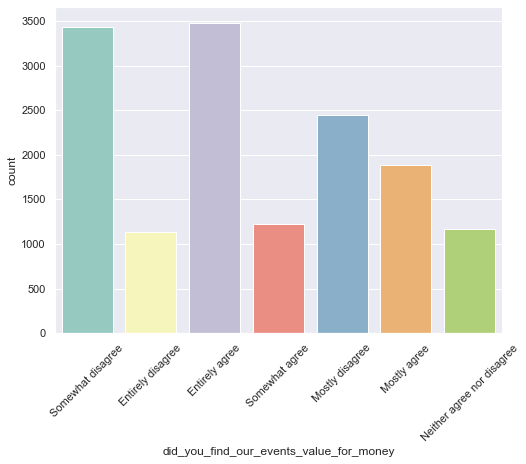

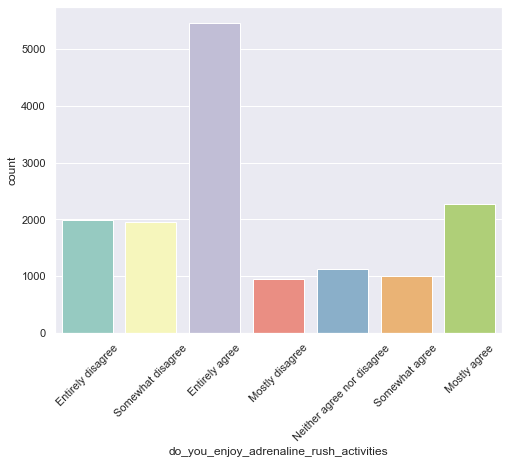

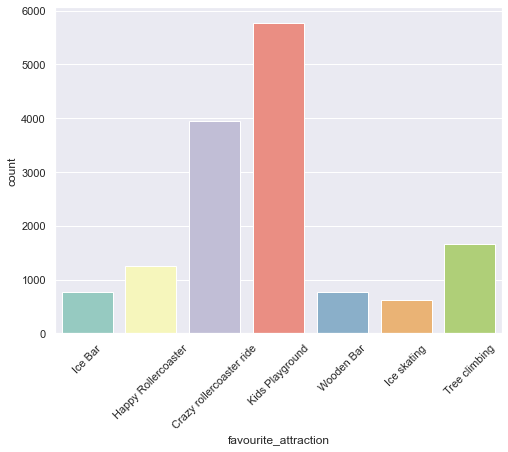

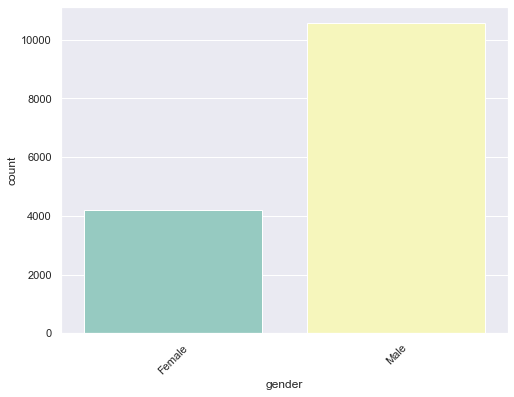

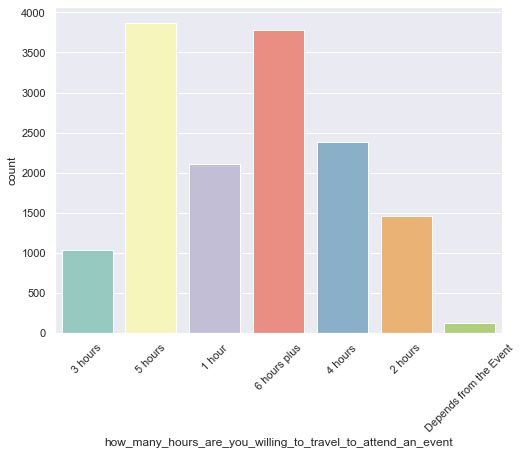

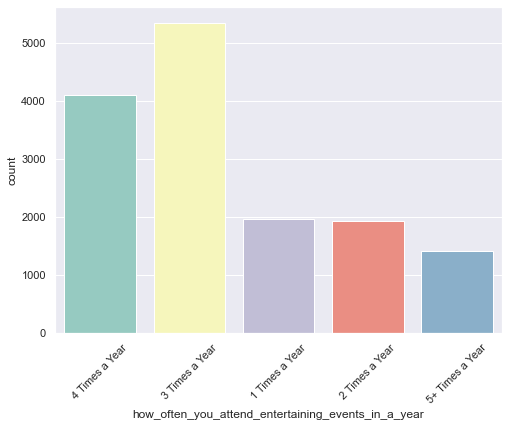

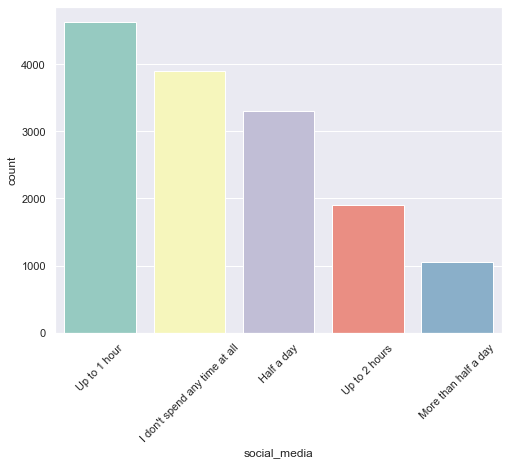

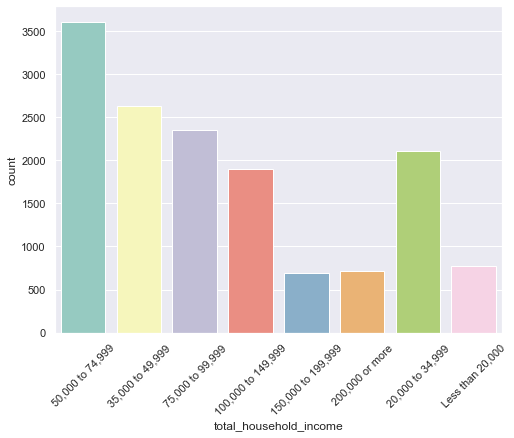

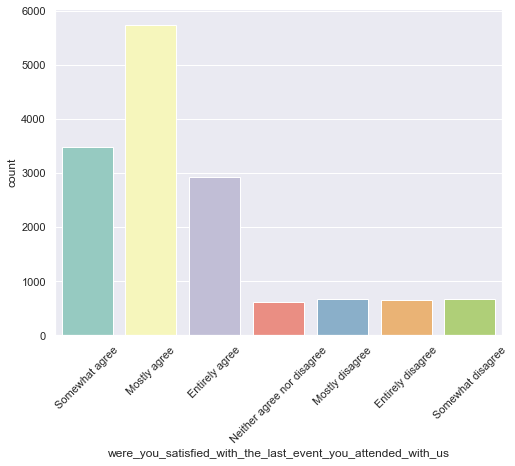

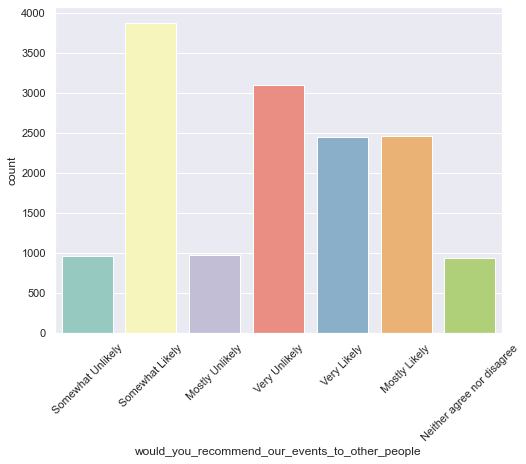

In [63]:
##########################################################
############ Visualising feature distributions ########### 
##########################################################
features = SQL_Query.columns.values
rem = ['id','district', 'constituency', 'postcode', 'latitude', 'longitude'] #remove location based features
features = np.setdiff1d(features, rem)
features

for f in features:
    sns.countplot(x = f, data = SQL_Query, palette = 'Set3')
    plt.xticks(rotation=45)
    plt.show()

In [70]:
##########################################################
######### Encode categorical variables to num. ########### 
##########################################################
# Original/raw data
print(f"Shape of original data: ", SQL_Query.shape)

# After feature removals
features_data = SQL_Query[features]
print(f"Shape of feature-removed data: ", features_data.shape)

# Encoded data shape
df = pd.get_dummies(raw_data, columns = features)
print(f"Shape of encoded data: ", df.shape)

df.head()

Shape of original data:  (14778, 19)
Shape of feature-removed data:  (14778, 13)
Shape of encoded data:  (14778, 86)


,age_17 or younger,age_18-20,age_21-25,age_26-32,age_33-39,age_40-49,age_50-59,age_60-64,age_65 or older,are_food_areas_important_to_you_Entirely agree,...,were_you_satisfied_with_the_last_event_you_attended_with_us_Neither agree nor disagree,were_you_satisfied_with_the_last_event_you_attended_with_us_Somewhat agree,were_you_satisfied_with_the_last_event_you_attended_with_us_Somewhat disagree,would_you_recommend_our_events_to_other_people_Mostly Likely,would_you_recommend_our_events_to_other_people_Mostly Unlikely,would_you_recommend_our_events_to_other_people_Neither agree nor disagree,would_you_recommend_our_events_to_other_people_Somewhat Likely,would_you_recommend_our_events_to_other_people_Somewhat Unlikely,would_you_recommend_our_events_to_other_people_Very Likely,would_you_recommend_our_events_to_other_people_Very Unlikely
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
